# Introduction
Andrew Jeffers, Haesung Jeong <br>
GitHub Repo Link: https://github.com/ajeffers999/CS598-Project

Project Video Link: https://drive.google.com/file/d/1q8SYeYhuX0JAGkiHEd1dMHqpRALThh7_/view?usp=drive_link

The paper explores an approach to determine how a patient's family members' medical history influences their disease risk. This is a meaningful problem because it could help inform patients about their risk for certain diseases based on relative and family information. Utlizing family medical history for predicting a patient's disease risk is also complicated by a variety of genetic, environmental, and lifestyle factors.

This paper proposes a novel solution to this problem by utilizing a graph-based deep learning approach for learning representations of family member's influence on patient's disease risk. A graph based approach is a more useful and natural way of modeling the connections between family members than previous methods.

Previous works have also recognized that it is useful to include information from family members when predicting the risk of disease. However, machine learning approaches using tabular data do not model the underlying geometric structure of family history. Using a graph based approach, this structure is much more easily obtained and modeled.

The main contributions of the paper are:
  * a scalable, disease-agnostic machine learning tool making use of GNNs and LSTMs which learn representations of a patient's disease risk from family member's medical information.
  * Data which shows graph-based approaches perform better than clinically-inspired or deep learning baselines used previously.
  * Graph explanability techniques demonstrate that GNN-LSTM embeddings identify medical features which are more suitable for predicting disease risk than features identifies by an epidemiological baseline.

The researchers observed that graph-based models consistently outperformed the baseline approaches, although the best performing model between GNN and GNN-LSTM varied depending on the disease in question. Cancers typically performed better on the GNN model, which the researchers believe is due to cancers generally being less hereditary than other diseases.

# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: Graph-based approaches predict disease risk better than the baseline model.
2.   Hypothesis 2: The GNN model using GraphConv layers predicts disease risk better than the GNN model using GCN layers.


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the experiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

# Python Version
Python 3.10.12

In [ ]:
!python --version

Python 3.10.12


# Libraries
Below are the Python libraries used to implement graph representation learning for familial relationships.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00


In [ ]:
# import  packages you need
import torch
import torch_geometric
import sqlite3
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset as GraphDataset
from torch_geometric.data import Batch
import torch_geometric.nn as gnn
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from tqdm import tqdm
from random import choices
import matplotlib.pyplot as plt
import time
import gdown

from google.colab import drive



## Data
### Data Download Instruction
The data for this project was obtained from https://github.com/dsgelab/family-EHR-graphs, as provided by the authors of the referenced paper. For our models, we only required specifiic files: the maskfile, featfile, adn edgefile. Consequently, we uploaded these files to our Goolge Drive. To facilitate access within this notebook, we employed the gdown library to download them directly.




In [ ]:
# Download files from Drive
raw_data_dir = '/content/'
gdown.download('https://drive.google.com/uc?id=1sRg8ACp8U7XvUoD8ftCI_e28efNjt1CA')
gdown.download('https://drive.google.com/uc?id=1MYIKBFS7SqaIGqx4XSKSPU2sBXhMnCLX')
gdown.download('https://drive.google.com/uc?id=1SU48XpEa90uutZv4vxZhJOWok_5tHMCI')
gdown.download('https://drive.google.com/uc?id=1p791BOVkPQtrettUMbC4nmYiACUFoHWy')
gdown.download('https://drive.google.com/uc?id=1oaDUoXpI3Rnhq2bdrsJT7eN6Pd7Yz0zN')
gdown.download('https://drive.google.com/uc?id=1kObsbqjlosFkqkvWcBJeiiFNFs6pnbL2')

Downloading...
From: https://drive.google.com/uc?id=1sRg8ACp8U7XvUoD8ftCI_e28efNjt1CA
To: /content/Gen3_50k_0.7_142857_statfile.csv
100%|██████████| 23.8M/23.8M [00:00<00:00, 38.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MYIKBFS7SqaIGqx4XSKSPU2sBXhMnCLX
To: /content/Gen3_50k_0.7_142857_maskfile.csv
100%|██████████| 3.00M/3.00M [00:00<00:00, 23.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SU48XpEa90uutZv4vxZhJOWok_5tHMCI
To: /content/Gen3_50k_0.7_142857_edgefile.csv
100%|██████████| 74.2M/74.2M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p791BOVkPQtrettUMbC4nmYiACUFoHWy
To: /content/featfile_A2.csv
100%|██████████| 380/380 [00:00<00:00, 1.19MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oaDUoXpI3Rnhq2bdrsJT7eN6Pd7Yz0zN
To: /content/featfile_A1.csv
100%|██████████| 56.0/56.0 [00:00<00:00, 144kB/s]
Downloading...
From: https://drive.google.com/uc?id=1kObsbqjlosFkqkvWcBJeiiFNFs6pnbL2
To: /content/featfile_G1.csv
10

'featfile_G1.csv'

In [ ]:
class DataFetch():
    """
    Class for fetching and formatting data

    Expects a tensor list of patients encoded using the numerical node_ids

    Assumes maskfile, statfile rows are indexed in order of these node_ids (0, 1, ... num_samples)
    and they include data for both the target and graph samples (retrieve data using .iloc)

    The edgefile only needs to include data for the target samples, and is indexed
    using the node_ids (retrieve data using .loc)

    Note that the featfile has exactly one label, corresponding to the label column name in the statfile

    Note if the input is a directed graph the code converts it to an undirected graph

    Parameters:
    maskfile, featfile, statfile and edgefile are filepaths to csv files
    sqlpath is the path to the sql database
    params is a dictionary of additional parameters (obs_window_start, obs_window_end)
    """
    def __init__(self, model_type, gnn_layer, featfile, alt_featfile=None, local=False):
        feat_df = pd.read_csv(raw_data_dir + featfile)
        statfile = pd.read_csv(raw_data_dir + 'Gen3_50k_0.7_142857_statfile.csv')

        self.local = local
        self.static_features = feat_df[feat_df['type']=='static']['name'].tolist()
        self.longitudinal_features = feat_df[feat_df['type']=='longitudinal']['name'].tolist()
        self.edge_features = feat_df[feat_df['type']=='edge']['name'].tolist()
        # some gnn layers only support a single edge weight
        if gnn_layer in ['gcn', 'graphconv']: self.edge_features=['weight']
        self.label_key = feat_df[feat_df['type']=='label']['name'].tolist()[0]
        self.static_data = torch.tensor(statfile[self.static_features].values, dtype=torch.float)
        self.label_data = torch.tensor(statfile[self.label_key].to_numpy(), dtype=torch.float32)

        if model_type in ['graph', 'graph_no_target', 'explainability']:
            # can specify a different feature set using alt_featfile
            alt_feat_df = pd.read_csv(raw_data_dir + alt_featfile)
            self.alt_static_features = alt_feat_df[alt_feat_df['type']=='static']['name'].tolist()
            self.alt_static_data = torch.tensor(statfile[self.alt_static_features].values, dtype=torch.float)

        mask_df = pd.read_csv(raw_data_dir + 'Gen3_50k_0.7_142857_maskfile.csv')
        self.id_map = dict(zip(mask_df['node_id'], mask_df['PATIENTID']))
        self.train_patient_list = torch.tensor(mask_df[mask_df['train']==0]['node_id'].to_numpy())
        self.validate_patient_list = torch.tensor(mask_df[mask_df['train']==1]['node_id'].to_numpy())
        self.test_patient_list = torch.tensor(mask_df[mask_df['train']==2]['node_id'].to_numpy())
        self.num_samples_train_minority_class = torch.sum(self.label_data[self.train_patient_list]==1).item()
        self.num_samples_train_majority_class = torch.sum(self.label_data[self.train_patient_list]==0).item()
        self.num_samples_valid_minority_class = torch.sum(self.label_data[self.validate_patient_list]==1).item()
        self.num_samples_valid_majority_class = torch.sum(self.label_data[self.validate_patient_list]==0).item()

        if model_type != 'baseline':
            self.edge_df = pd.read_csv(raw_data_dir + 'Gen3_50k_0.7_142857_edgefile.csv')
            self.edge_df = self.edge_df.groupby('target_patient').agg(list)

    def get_static_data(self, patients):
        x_static = self.static_data[patients]
        y = self.label_data[patients]
        return x_static, y

    def get_alt_static_data(self, patients):
        x_static = self.alt_static_data[patients]
        return x_static

    def get_longitudinal_data(self, patients):
        if self.local:
            # return simulated data for local testing
            num_nodes = len(patients)
            num_years = self.params['obs_window_end']-self.params['obs_window_start']+1
            num_features = len(self.longitudinal_features)
            num_data = int(num_nodes*num_years*num_features*0.01)
            i = [choices(range(num_nodes),k=num_data), choices(range(num_years),k=num_data), choices(range(num_features),k=num_data)]
            v = [1]*num_data
            x_longitudinal = torch.sparse_coo_tensor(i, v, (num_nodes, num_years, num_features), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()
        else:
            # fetch data from SQLite database
            id_list = [self.id_map[patient.item()] for patient in patients]
            data = pd.DataFrame()
            for patient in id_list:
                command = "SELECT PATIENTID, EVENT_YEAR, ENDPOINT FROM long WHERE PATIENTID='{}'".format(patient)
                data = pd.concat([data, pd.read_sql_query(command, self.conn)])
            data = data[data['ENDPOINT'].isin(self.longitudinal_features)]

            # limit to observation window years
            data['EVENT_YEAR'] = data['EVENT_YEAR'].astype(int)
            data = data[(data['EVENT_YEAR']>=self.params['obs_window_start'])&(data['EVENT_YEAR']<=self.params['obs_window_end'])]

            # map to index positions
            node_index = dict(zip(id_list, range(len(id_list))))
            year_index = dict(zip(np.arange(self.params['obs_window_start'], self.params['obs_window_end']+1), range(self.params['obs_window_end']-self.params['obs_window_start']+1)))
            feat_index = dict(zip(self.longitudinal_features, range(len(self.longitudinal_features))))
            data['PATIENTID'] = data['PATIENTID'].map(node_index)
            data['EVENT_YEAR'] = data['EVENT_YEAR'].map(year_index)
            data['ENDPOINT'] = data['ENDPOINT'].map(feat_index)

            # create sparse tensor
            i = [data['PATIENTID'].tolist(), data['EVENT_YEAR'].tolist(), data['ENDPOINT'].tolist()]
            v = [1]*len(data)
            x_longitudinal = torch.sparse_coo_tensor(i, v, (len(node_index), len(year_index), len(feat_index)), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()

        return x_longitudinal_dense

    def get_relatives(self, patients):
        """Returns a list of node ids included in any of these patient graphs
        """
        return torch.tensor(list(set([i for list in self.edge_df.loc[patients]['node1'].to_list() for i in list] + [i for list in self.edge_df.loc[patients]['node2'].to_list() for i in list])))

    def construct_patient_graph(self, patient, all_relatives, all_x_static, all_y, all_x_longitudinal=None):
        """Creates a re-indexed pytorch geometric data object for the patient
        """
        # order nodes and get indices in all_relatives to retrieve feature data
        node_ordering = np.asarray(list(set(self.edge_df.loc[patient].node1 + self.edge_df.loc[patient].node2)))
        node_indices = [list(all_relatives.tolist()).index(value) for value in node_ordering]
        x_static = all_x_static[node_indices]
        y = all_y[list(all_relatives.tolist()).index(patient)] # predicting single value for each graph

        # reindex the edge indices from 0, 1, ... num_nodes
        node1 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node1]
        node2 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node2]
        edge_index = torch.tensor([node1,node2], dtype=torch.long)
        edge_weight = torch.t(torch.tensor(self.edge_df.loc[patient][self.edge_features], dtype=torch.float))

        data = torch_geometric.data.Data(x=x_static, edge_index=edge_index, y=y, edge_attr=edge_weight)
        transform = torch_geometric.transforms.ToUndirected(reduce='mean')
        data = transform(data)
        if all_x_longitudinal is not None: data.x_longitudinal = all_x_longitudinal[node_indices]
        data.target_index = torch.tensor(list(node_ordering.tolist()).index(patient))
        return data


class Data(Dataset):
    def __init__(self, patient_list, fetch_data):
        """
        Loads non-graph datasets for a given list of patients
        Returns (x_static, x_longitudinal, y) if longitudinal data included, else (x_static, y)
        """
        self.patient_list = patient_list
        self.num_target_patients = len(patient_list)
        self.fetch_data = fetch_data
        self.include_longitudinal = len(fetch_data.longitudinal_features)>0

    def __getitem__(self, patients):
        batch_patient_list = self.patient_list[patients]
        x_static, y = self.fetch_data.get_static_data(batch_patient_list)
        if self.include_longitudinal:
            x_longitudinal = self.fetch_data.get_longitudinal_data(batch_patient_list)
            return x_static, x_longitudinal, y
        else:
            return x_static, y

    def __len__(self):
        return self.num_target_patients


class GraphData(GraphDataset):
  def __init__(self, patient_list, fetch_data):
      """
      Loads a batch of multiple patient graphs
      """
      self.patient_list = patient_list
      self.num_target_patients = len(patient_list)
      self.fetch_data = fetch_data
      self.include_longitudinal = len(fetch_data.longitudinal_features)>0

  def __getitem__(self, patients):
      # returns multiple patient graphs by constructing a pytorch geometric Batch object
      batch_patient_list = self.patient_list[patients]
      data_list = []

      # it's more efficient to fetch feature data for all patients and their relatives,
      # and then split into separate graphs
      all_relatives = self.fetch_data.get_relatives(batch_patient_list)
      all_x_static, all_y = self.fetch_data.get_static_data(all_relatives)
      patient_x_static = self.fetch_data.get_alt_static_data(batch_patient_list)
      if self.include_longitudinal: all_x_longitudinal = self.fetch_data.get_longitudinal_data(all_relatives)
      else: all_x_longitudinal = None

      patient_index = 0
      for patient in batch_patient_list:
        patient_graph = self.fetch_data.construct_patient_graph(patient.item(), all_relatives, all_x_static, all_y, all_x_longitudinal)
        patient_graph.patient_x_static = patient_x_static[patient_index].reshape(1,-1)
        if self.include_longitudinal:
            patient_x_longitudinal = patient_graph.x_longitudinal[patient_graph.target_index]
            patient_graph.patient_x_longitudinal = patient_x_longitudinal[None,:,:]
        data_list.append(patient_graph)
        patient_index += 1

      batch_data = Batch.from_data_list(data_list)
      return batch_data

  def __len__(self):
      return self.num_target_patients

In [ ]:
def get_data_and_loader(patient_list, fetch_data, model_type, batch_size, shuffle=True):
    """
    Parameters:
    patient_list: list of patients (target samples) to load data for
    fetch_data: the data object
    params: dictionary of other parameters
    shuffle: samples in random order if true
    """
    if model_type == 'baseline':
        dataset = Data(patient_list, fetch_data)
    elif model_type in ['graph', 'graph_no_target', 'explainability']:
        dataset = GraphData(patient_list, fetch_data)

    if shuffle:
        sample_order = torch.utils.data.sampler.RandomSampler(dataset)
    else:
        sample_order = torch.utils.data.sampler.SequentialSampler(dataset)

    sampler = torch.utils.data.sampler.BatchSampler(
        sample_order,
        batch_size=batch_size,
        drop_last=False)

    loader = DataLoader(dataset, sampler=sampler, num_workers=1)
    return dataset, loader


## Data Description
### Source of the data
The data is sourced from the Github repository at https://github.com/dsgelab/family-EHR-graphs. Since the paper relies on a nationwide health registry dataset that cannot be publicly shared due to privacty concerns, this dataset is designed to mimic the key properties of the actual data.

### Statistics
This is synthetic data, which means we are able to
  choose the amount of data we would like to use. In this case, we are using 150000 number of rows. Out of 150000 rows, 57297 are marked as True and 92703 are marked as False

### Data process
We are splitting the data into an 80/20 train/test split. For example, for baseline non-longitudinal data, we are only usig 39,297 rows of data. For training, we are using 31,437 rows of data andn 7860 for testing. As this is synthetic data, there is little to no cleaning required.


<br>Below is an example of the sample data we utilized to train, validate, and test our baseline model

static_data:  150000
label data:  150000
True label:  57297.0
False label:  92703.0


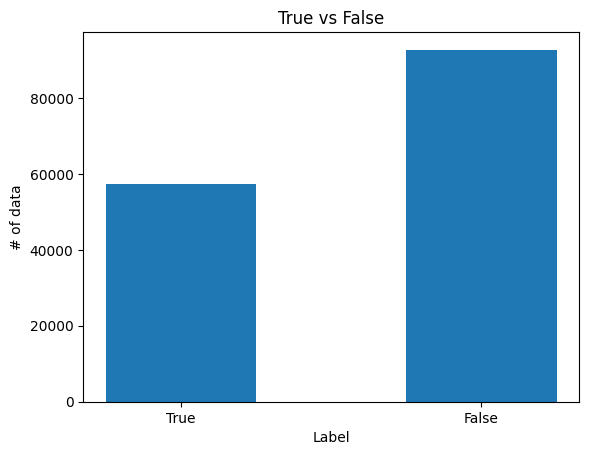

<Figure size 640x480 with 0 Axes>

In [ ]:
model_type='baseline'
fetch_data = DataFetch(model_type=model_type, featfile='featfile_A2.csv', gnn_layer='graphconv')
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
num_features_static = len(fetch_data.static_features)
num_samples_train_dataset = len(train_patient_list)
num_samples_valid_dataset = len(validate_patient_list)
num_samples_train_minority_class = fetch_data.num_samples_train_minority_class
num_samples_valid_minority_class = fetch_data.num_samples_valid_minority_class
num_samples_train_majority_class = fetch_data.num_samples_train_majority_class
num_samples_valid_majority_class = fetch_data.num_samples_valid_majority_class

print('static_data: ', len(fetch_data.static_data))
print('label data: ', len(fetch_data.label_data))
print('True label: ', fetch_data.label_data.sum().item())
print('False label: ', len(fetch_data.label_data) -fetch_data.label_data.sum().item())

plt.bar(['True', 'False'], [fetch_data.label_data.sum().item(), len(fetch_data.label_data) - fetch_data.label_data.sum().item()], width=0.5)
plt.title('True vs False')
plt.xlabel('Label')
plt.ylabel('# of data')
plt.show()
plt.clf()

Train dataset:  27565
Validate dataset:  3872
Test dataset:  7860


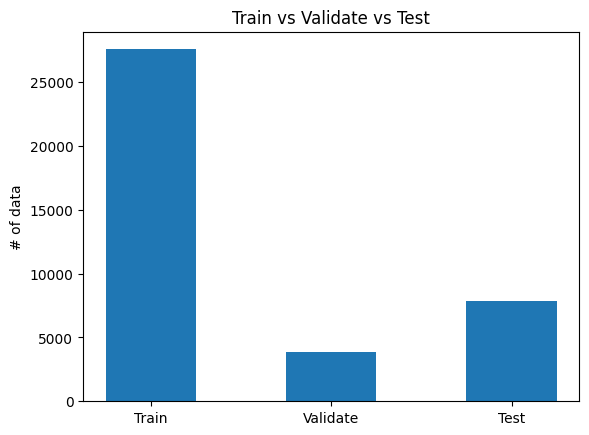

<Figure size 640x480 with 0 Axes>

In [ ]:
print('Train dataset: ', len(train_patient_list))
print('Validate dataset: ', len(validate_patient_list))
print('Test dataset: ', len(fetch_data.test_patient_list))

plt.bar(['Train', 'Validate', 'Test'], [len(train_patient_list), len(validate_patient_list), len(fetch_data.test_patient_list)], width=0.5)
plt.title('Train vs Validate vs Test')
plt.ylabel('# of data')
plt.show()
plt.clf()


##   Model
The model includes the model definition which usually is a class, model training, and other necessary parts. The described models discussed and based on the research paper and its Github repository at https://github.com/dsgelab/family-EHR-graphs [1].

* Training Objectives: We are using the Adam optimizer and the WeightedBCELoss loss function. Our dropout rate is 0.5 and our learning rate is 0.001.

  ### Baseline Model
  * Model architecture: The Baseline Model has three linear layers, with a ReLU activation function, Sigmoid activation function, and a Dropout layer.
  * The model is not pretrained, and the training code is shown below.

  ### GNN Model
  * Model Architecture: The GNN model can be customized more than the Baseline model. There are two GNN layers in use in this model, which can be one of three types: GCN, GraphConv, or GAT. Additionally, there can be one of many types of pooling methods: target, sum, mean, etc. The model also has quite a few linear layers that is chooses between based on for different parts of the data. One final Linear layer is used to retrieve patient results, and a different final Linear layer is used to retrieve family results.
  * The model is not pretrained, and the training code is shown below.


  <br>
  1. Sun, J, "Characterizing personalized effects of family information on disease risk using graph representation learning.", Proceedings of Machine Learning Research, 2023, 219:1–25, doi: https://doi.org/10.48550/arXiv.2304.05010

In [ ]:
class Baseline(torch.nn.Module):
    def __init__(self, num_features_static, hidden_dim, dropout_rate):
        super().__init__()
        self.static_linear1 = nn.Linear(num_features_static, hidden_dim)
        self.static_linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.final_linear = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static):
        linear_out = self.relu(self.static_linear1(x_static))
        linear_out = self.relu(self.static_linear2(linear_out))
        linear_out = self.dropout(linear_out)
        out = self.sigmoid(self.final_linear(linear_out))
        return out

class GNN(torch.nn.Module):
    def __init__(self, num_features_static_graph, num_features_static_node, hidden_dim, gnn_layer, pooling_method, dropout_rate, ratio):
        super().__init__()
        self.pooling_method = pooling_method
        self.static_linear1 = nn.Linear(num_features_static_node, hidden_dim)
        self.static_linear2 = nn.Linear(hidden_dim, hidden_dim)

        # which gnn layer to use is specified by input argument
        if gnn_layer=='gcn':
            print("Using GCN layers")
            self.conv1 = gnn.GCNConv(num_features_static_graph, hidden_dim)
            self.conv2 = gnn.GCNConv(hidden_dim, hidden_dim)
        if gnn_layer=='graphconv':
            print("Using GraphConv layers")
            self.conv1 = gnn.GraphConv(num_features_static_graph, hidden_dim)
            self.conv2 = gnn.GraphConv(hidden_dim, hidden_dim)
        elif gnn_layer=='gat':
            print("Using GAT layers")
            self.conv1 = gnn.GATConv(num_features_static_graph, hidden_dim)
            self.conv2 = gnn.GATConv(hidden_dim, hidden_dim)

        self.pre_final_linear = nn.Linear(2*hidden_dim, hidden_dim)
        self.final_linear_com = nn.Linear(hidden_dim, 1)
        self.final_linear = nn.Linear(hidden_dim, 1)
        self.final_linear1 = nn.Linear(hidden_dim, 1)
        self.final_linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.TopKpool = gnn.TopKPooling(hidden_dim, ratio=ratio)
        self.SAGpool = gnn.SAGPooling(hidden_dim, ratio=ratio)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index):
        # patient part of the network
        linear_out = self.relu(self.static_linear1(x_static_node))
        linear_out = self.relu(self.static_linear2(linear_out))
        patient_out = self.dropout(linear_out)

        # family part of the network
        gnn_out = self.relu(self.conv1(x_static_graph, edge_index, edge_weight))
        gnn_out = self.relu(self.conv2(gnn_out, edge_index, edge_weight))

        if self.pooling_method=='target':
            out = gnn_out[target_index] # instead of pooling, use the target node embedding
        elif self.pooling_method=='sum':
            out = gnn.global_add_pool(gnn_out, batch)
        elif self.pooling_method=='mean':
            out = gnn.global_mean_pool(gnn_out, batch)
        elif self.pooling_method=='topkpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='topkpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)

        family_out = self.dropout(out)

        # combined part of network (classifiation output)
        out = torch.cat((patient_out, family_out), 1)
        out = self.relu(self.pre_final_linear(out))
        out = self.sigmoid(self.final_linear_com(out))
        # separate output heads for different parts of the network (for loss calculations)
        patient_out = self.sigmoid(self.final_linear1(patient_out))
        family_out = self.sigmoid(self.final_linear2(family_out))
        return out, patient_out, family_out

# Custom Loss function
Class imbalance arises because the models are predicting diseases with prevalence < 10% in the selected cohorts. The authors of the paper alleviate this by using class-weighted loss functions, sampling strategies designed for imbalanced classification, methods to prevent overfitting, and careful choice and interpretation of evaluation metrics (Wharrie, Sophie, et al.).


In [ ]:
class WeightedBCELoss(torch.nn.Module):
    def __init__(self, num_samples_dataset, num_samples_minority_class, num_samples_majority_class):
        super(WeightedBCELoss,self).__init__()
        self.num_samples_dataset = num_samples_dataset
        self.num_samples_minority_class = num_samples_minority_class
        self.num_samples_majority_class = num_samples_majority_class

    def forward(self, y_est, y):
        weight_minority = self.num_samples_dataset / self.num_samples_minority_class
        weight_majority = self.num_samples_dataset / self.num_samples_majority_class
        class_weights = torch.tensor([[weight_minority] if i==1 else [weight_majority] for i in y])
        bce_loss = torch.nn.BCELoss(weight=class_weights)
        weighted_bce_loss = bce_loss(y_est, y)
        return weighted_bce_loss


Calculate Metrics from the output

In [ ]:
def brier_skill_score(actual_y, predicted_prob_y):
    e = sum(actual_y) / len(actual_y)
    bs_ref = sum((e-actual_y)**2) / len(actual_y)
    bs = sum((predicted_prob_y-actual_y)**2) / len(actual_y)
    bss = 1 - bs / bs_ref
    return bss

def calculate_metrics(actual_y, predicted_y, predicted_prob_y):
    auc_roc = metrics.roc_auc_score(actual_y, predicted_prob_y)
    precision, recall, thresholds = metrics.precision_recall_curve(actual_y, predicted_prob_y)
    auc_prc = metrics.auc(recall, precision)
    mcc = metrics.matthews_corrcoef(actual_y, predicted_y)
    tn, fp, fn, tp = metrics.confusion_matrix(actual_y, predicted_y).ravel()
    ts = tp / (tp + fn + fp)
    recall = tp / (tp + fn)
    f1 = (2*tp) / (2*tp + fp + fn)
    bss = brier_skill_score(actual_y, predicted_prob_y)

    metric_results = {'metric_auc_roc':auc_roc, # typically reported, but can be biased for imbalanced classes
               'metric_auc_prc':auc_prc, # better suited for imbalanced classes
               'metric_f1':f1, # also should be better suited for imbalanced classes
               'metric_recall':recall, # important for medical studies, to reduce misses of positive instances
               'metric_mcc':mcc, # correlation that is suitable for imbalanced classes
               'metric_ts':ts, # suited for rare events, penalizing misclassification as the rare event (fp)
               'metric_bss':bss, # brier skill score, where higher score corresponds better calibration of predicted probabilities
               'true_negatives':tn,
               'false_positives':fp,
               'false_negatives':fn,
               'true_positives':tp}

    return metric_results

### Early Stopping technique
Early stops the training if validation loss doesn't improve after a given patience.

In [ ]:
class EarlyStopping:
    """
    Ref. https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=5, verbose=False, delta=1, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 1
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Plot Metrics
Functions to make plots for metrics and save them to Google Drive

In [ ]:
def plot_separate_losses(network_losses, target_losses, family_losses, model_type, isTrain):
    plt.plot(network_losses, label='Network')
    plt.plot(target_losses, label='Target')
    plt.plot(family_losses, label='Family')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if model_type == 'gcn':
      if isTrain:
        plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/gnn_gcn_train_separate_loss.png')
      else:
        plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/gnn_gcn_valid_separate_loss.png')
    else:
      if isTrain:
        plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/gnn_graphconv_train_separate_loss.png')
      else:
        plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/gnn_graphconv_valid_separate_loss.png')
    plt.clf()

def plot_losses(train_losses, valid_losses, model_type):
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validate')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if model_type == 'gcn':
      plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/gnn_gcn_loss.png')
    elif model_type == 'graphconv':
      plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/gnn_graphconv_loss.png')
    else:
      plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/baseline_loss.png')
    plt.clf()

## Training

# Hyperparameters
learnig rate = 0.001
<br>batch size = 250
<br>dropout = 0.5

# Computational requirements
hardware = cpu
<br>Number of CPU = 2
<br>model name = Intel(R) Xeon(R) CPU @ 2.20GHz
<br>Number of maximum training epochs = 100


In [ ]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.208
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.41
clflush size	: 64
cache_ali

## Training

**Baseline A2 - Age, Sex, and family history MLP**

In [ ]:
batch_size=250
main_hidden_dim = 20
lstm_hidden_dim = 20
dropout_rate = 0.5
learning_rate = 0.001
num_batches_train = int(np.ceil(len(train_patient_list)/batch_size))
num_batches_validate = int(np.ceil(len(validate_patient_list)/batch_size))

model = Baseline(num_features_static, main_hidden_dim, dropout_rate)

loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)


**Below is the traing step used to generate the checkpoint file**

In [ ]:
# This code snippet does not need to run since we already have a model checkpoint created for this.
# num_batches_train = int(np.ceil(len(train_patient_list)/batch_size))
# num_batches_validate = int(np.ceil(len(validate_patient_list)/batch_size))

# model = Baseline(num_features_static, main_hidden_dim, dropout_rate)
# loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
# valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
# validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)

# model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/baseline.pt'
# train_model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/train-baseline.pt'
# num_epoch = 100

# # model training loop: it is better to print the training/validation losses during the training
# early_stopping = EarlyStopping(path=train_model_path)
# train_losses = []
# valid_losses = []
# separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

# for i in range(num_epoch):
#   model.train()
#   epoch_train_loss = []
#   separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}
#   for train_batch in tqdm(train_loader, total=num_batches_train):
#     x_static, y = train_batch[0][0], train_batch[1][0].unsqueeze(1)
#     output = model(x_static)
#     loss = loss_func(output, y)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     epoch_train_loss.append(loss.item())

#   # eval on validset
#   model.eval()
#   epoch_valid_loss = []
#   valid_output = np.array([])
#   valid_y = np.array([])
#   for valid_batch in tqdm(validate_loader, total=num_batches_validate):
#     x_static, y = valid_batch[0][0], valid_batch[1][0].unsqueeze(1)
#     output = model(x_static)
#     valid_output = np.concatenate((valid_output, output.reshape(-1).detach().cpu().numpy()))
#     valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

#     loss = valid_loss_func(output, y)
#     epoch_valid_loss.append(loss.item())

#   train_loss, valid_loss = np.mean(epoch_train_loss), np.mean(epoch_valid_loss)
#   train_losses.append(train_loss)
#   valid_losses.append(valid_loss)

#   for term_name in separate_loss_terms:
#     separate_loss_terms[term_name].append(np.mean(separate_loss_terms_epoch[term_name]))
#   print("epoch {}\ttrain loss : {}\tvalidate loss : {}".format(i, np.mean(epoch_train_loss), np.mean(epoch_valid_loss)))
#   early_stopping(np.mean(epoch_valid_loss), model)
#   if early_stopping.early_stop:
#     print('Early Stopping')
#     break

# fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_output)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# threshold = thresholds[ix]

# plot_losses(train_losses, valid_losses, 'baseline')
# torch.save({
#     'epoch': num_epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses,
#     'valid_losses': valid_losses,
#     'threshold': threshold
#     }, model_path)

  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 91%|█████████ | 101/111 [00:01<00:00, 102.43it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:00<00:00, 90.58it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch 0	train loss : 1.4138914787017547	validate loss : 1.3762345910072327


100%|██████████| 16/16 [00:00<00:00, 90.99it/s]


epoch 1	train loss : 1.381872318886422	validate loss : 1.371186338365078
EarlyStopping counter: 1 out of 5


100%|██████████| 16/16 [00:00<00:00, 96.51it/s]


epoch 2	train loss : 1.3488691282701921	validate loss : 1.317891076207161
EarlyStopping counter: 2 out of 5


100%|██████████| 16/16 [00:00<00:00, 97.85it/s]


epoch 3	train loss : 1.3014025419681996	validate loss : 1.2488487660884857
EarlyStopping counter: 3 out of 5


100%|██████████| 16/16 [00:00<00:00, 94.46it/s]


epoch 4	train loss : 1.242074469188312	validate loss : 1.188820205628872
EarlyStopping counter: 4 out of 5


100%|██████████| 16/16 [00:00<00:00, 94.17it/s]


epoch 5	train loss : 1.215760852302517	validate loss : 1.1728611774742603
EarlyStopping counter: 5 out of 5
Early Stopping


<Figure size 640x480 with 0 Axes>


# Results
Baseline:<br>
* Area Under the Receiver Operating Characteristic Curve (auc_roc): 0.7423616531503197
* Compute Area Under the Curve (auc): 0.24469842750122853<br>
* F1 score: 0.3078584931136916<br>
* Recall: 0.6529209621993127<br>
* MCC: 0.21566619661004827

GNN (graphconv):<br>
* Area Under the Receiver Operating Characteristic Curve (auc_roc): 0.7561574424503961
* Compute Area Under the Curve (auc): 0.2501534301041718<br>
* F1 score: 0.3313351498637602<br>
* Recall: 0.6964490263459335<br>
* MCC: 0.25146318920227423

GNN (gcn):<br>
* Area Under the Receiver Operating Characteristic Curve (auc_roc): 0.7582678910645871
* Compute Area Under the Curve (auc): 0.2615118219594704<br>
* F1 score: 0.33721922092692636<br>
* Recall: 0.6792668957617412<br>
* MCC: 0.2565234631792809




Downloading...
From: https://drive.google.com/uc?id=15w1eJRql0MzIBu5x4sxJYYS7hrXvRCO2
To: /content/baseline.pt
100%|██████████| 16.9k/16.9k [00:00<00:00, 29.9MB/s]
  0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [00:00<00:00, 206.13it/s]


{'metric_auc_roc': 0.7423616531503197, 'metric_auc_prc': 0.24469842750122853, 'metric_f1': 0.3078584931136916, 'metric_recall': 0.6529209621993127, 'metric_mcc': 0.21566619661004827, 'metric_ts': 0.1819342483242898, 'metric_bss': -1.6441961381599373, 'true_negatives': 4727, 'false_positives': 2260, 'false_negatives': 303, 'true_positives': 570}


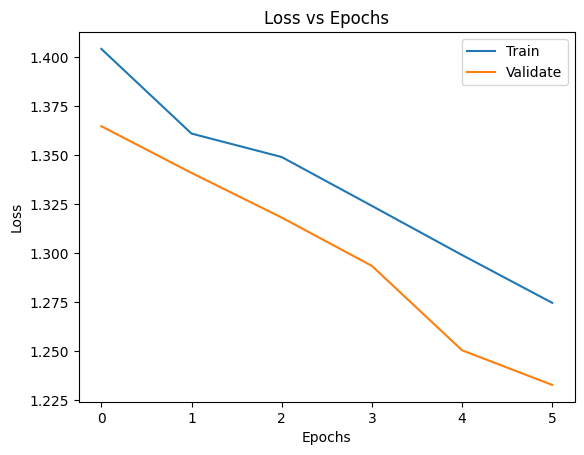

<Figure size 640x480 with 0 Axes>

In [ ]:
# Download model checkpoint
gdown.download('https://drive.google.com/uc?id=15w1eJRql0MzIBu5x4sxJYYS7hrXvRCO2')
checkpoint = torch.load('/content/baseline.pt')
model = Baseline(num_features_static, main_hidden_dim, dropout_rate)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

baseline_train_losses = checkpoint['train_losses']
baseline_valid_losses = checkpoint['valid_losses']
baseline_threshold = checkpoint['threshold']

# Test
num_samples = 3
baseline_test_output = [np.array([]) for _ in range(num_samples)]
baseline_test_y = [np.array([]) for _ in range(num_samples)]
representations = pd.DataFrame()

test_patient_list = fetch_data.test_patient_list
num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

for m in model.modules():
  if m.__class__.__name__.startswith('Dropout'):
    m.train()

for sample in range(num_samples):
    for test_batch in tqdm(test_loader, total=num_batches_test):
        x_static, y = test_batch[0][0], test_batch[1][0].unsqueeze(1)
        output = model(x_static)
        baseline_test_output[sample] = np.concatenate((baseline_test_output[sample], output.reshape(-1).detach().cpu().numpy()))
        baseline_test_y[sample] = np.concatenate((baseline_test_y[sample], y.reshape(-1).detach().cpu().numpy()))

# metrics to evaluate my model
plot_losses(baseline_train_losses, baseline_valid_losses, 'baseline')

# report standard error for uncertainty
baseline_test_output_se = np.array(baseline_test_output).std(axis=0) / np.sqrt(num_samples)

# take average over all samples to get expected value
baseline_test_output = np.array(baseline_test_output).mean(axis=0)
baseline_test_y = np.array(baseline_test_y).mean(axis=0)

baseline_results = pd.DataFrame({'actual':baseline_test_y, 'pred_raw':baseline_test_output, 'pred_raw_se':baseline_test_output_se})
baseline_results['pred_binary'] = (baseline_results['pred_raw']>baseline_threshold).astype(int)
baseline_metric_results = calculate_metrics(baseline_results['actual'], baseline_results['pred_binary'], baseline_results['pred_raw'])
print(baseline_metric_results)

# plot figures to better show the results
plt.plot(baseline_train_losses, label='Train')
plt.plot(baseline_valid_losses, label='Validate')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()


**Baseline Model Loss:**

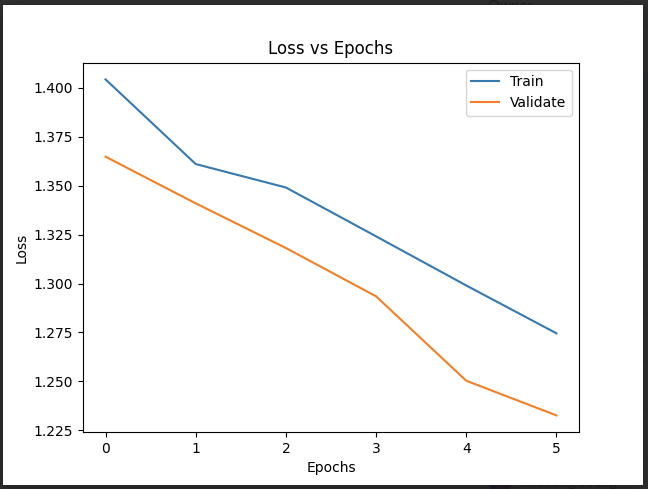

## Model comparison

# GraphConv Graph model
The GNN model using GraphConv layers for non-longitudinal data.

In [ ]:
# Declare data variables, loss function, and optimizer
model_type = 'graph'
gnn_layer='graphconv'
pooling_method = 'target'
main_hidden_dim=20 # used for both GNN and MLP
lstm_hidden_dim=20 # x2 for bidirectional LSTM
ratio = 0.5
gamma = 1
alpha = 1
beta = 1
delta = 1
batch_size=250
dropout_rate = 0.5
learning_rate = 0.001

fetch_data = DataFetch(model_type=model_type, featfile='featfile_G1.csv', gnn_layer=gnn_layer, alt_featfile='featfile_A2.csv')
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
num_features_static = len(fetch_data.static_features)
num_features_alt_static = len(fetch_data.alt_static_features)
num_samples_train_dataset = len(train_patient_list)
num_samples_valid_dataset = len(validate_patient_list)
num_samples_train_minority_class = fetch_data.num_samples_train_minority_class
num_samples_valid_minority_class = fetch_data.num_samples_valid_minority_class
num_samples_train_majority_class = fetch_data.num_samples_train_majority_class
num_samples_valid_majority_class = fetch_data.num_samples_valid_majority_class

model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, gnn_layer, pooling_method, dropout_rate, ratio)

loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)

print('static_data: ', len(fetch_data.static_data))
print('label data: ', len(fetch_data.label_data))
print('True label: ', fetch_data.label_data.sum().item())
print('False label: ', len(fetch_data.label_data) -fetch_data.label_data.sum().item())
print('Train dataset: ', len(train_patient_list))
print('Validate dataset: ', len(validate_patient_list))
print('Test dataset: ', len(fetch_data.test_patient_list))

Using GraphConv layers
static_data:  150000
label data:  150000
True label:  57297.0
False label:  92703.0
Train dataset:  27565
Validate dataset:  3872
Test dataset:  7860


**Below training step is used to generate checkpoint file 'gnn-graphconv.pt'**
<br>you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

In [ ]:
# compare you model with others
# start_time_train = time.time()
# num_epoch = 100
# num_batches_train = int(np.ceil(len(train_patient_list)/batch_size))
# num_batches_validate = int(np.ceil(len(validate_patient_list)/batch_size))

# # model training loop: it is better to print the training/validation losses during the training
# train_losses = []
# valid_losses = []
# separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

# model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/gnn-graphconv.pt'
# train_model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/train-gnn-graphconv.pt'
# graphconv_early_stopping = EarlyStopping(path=train_model_path)

# for i in range(num_epoch):
#   model.train()
#   epoch_train_loss = []
#   separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

#   for train_batch in tqdm(train_loader, total=num_batches_train):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)

#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * loss_func(output, y)
#     loss_term_target = alpha * loss_func(patient_output, y)
#     loss_term_family = beta * loss_func(family_output, y)

#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())

#     loss = loss_term_NN + loss_term_target + loss_term_family

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     epoch_train_loss.append(loss.item())

#   # eval on validset
#   model.eval()
#   epoch_valid_loss = []
#   valid_output = np.array([])
#   valid_y = np.array([])
#   for valid_batch in tqdm(validate_loader, total=num_batches_validate):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = valid_batch.patient_x_static, valid_batch.x, valid_batch.y.unsqueeze(1), valid_batch.edge_index, valid_batch.edge_attr, valid_batch.batch, valid_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)

#     valid_output = np.concatenate((valid_output, output.reshape(-1).detach().cpu().numpy()))
#     valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * valid_loss_func(output, y)
#     loss_term_target = alpha * valid_loss_func(patient_output, y)
#     loss_term_family = beta * valid_loss_func(family_output, y)

#     separate_loss_terms_epoch['NN_valid'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_valid'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_valid'].append(loss_term_family.item())

#     loss = loss_term_NN + loss_term_target + loss_term_family
#     epoch_valid_loss.append(loss.item())

#   train_loss, valid_loss = np.mean(epoch_train_loss), np.mean(epoch_valid_loss)
#   train_losses.append(train_loss)
#   valid_losses.append(valid_loss)

#   for term_name in separate_loss_terms:
#     separate_loss_terms[term_name].append(np.mean(separate_loss_terms_epoch[term_name]))
#   print("epoch {}\ttrain loss : {}\tvalidate loss : {}".format(i, train_loss, valid_loss))

#   graphconv_early_stopping(np.mean(epoch_valid_loss), model)
#   if graphconv_early_stopping.early_stop:
#     print('Early Stopping')
#     break

# fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_output)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# auc_threshold = thresholds[ix]

# pr_thresholds = np.arange(0.1, 0.9, 0.001) # between 0.1 and 0.9 to exclude trivial values like 0 and 1
# scores = [metrics.f1_score(valid_y, (valid_output >= t).astype('int')) for t in pr_thresholds]
# pr_ix = np.argmax(scores)
# pr_threshold = pr_thresholds[pr_ix]

# plot_losses(train_losses, valid_losses, 'graphconv')
# plot_separate_losses(separate_loss_terms['NN_train'], separate_loss_terms['target_train'], separate_loss_terms['family_train'], 'graphconv', True)
# plot_separate_losses(separate_loss_terms['NN_valid'], separate_loss_terms['target_valid'], separate_loss_terms['family_valid'], 'graphconv', False)

# end_time_train = time.time()
# torch.save({
#     'epoch': num_epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'threshold': auc_threshold,
#     'start_time': start_time_train,
#     'end_time': end_time_train
#     }, model_path)
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 111/111 [02:01<00:00,  1.34it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:16<00:00,  1.05s/it]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch 0	train loss : 7.134208290426581	validate loss : 4.1087020337581635


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


epoch 1	train loss : 4.139859311215512	validate loss : 4.124679610133171
EarlyStopping counter: 1 out of 5


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


epoch 2	train loss : 4.112498246871673	validate loss : 4.036566853523254
EarlyStopping counter: 2 out of 5


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


epoch 3	train loss : 4.047164906252612	validate loss : 3.9392164796590805
EarlyStopping counter: 3 out of 5


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


epoch 4	train loss : 3.9511228982392734	validate loss : 3.8099250346422195
EarlyStopping counter: 4 out of 5


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


epoch 5	train loss : 3.849997937142312	validate loss : 3.741437718272209
EarlyStopping counter: 5 out of 5
Early Stopping


<Figure size 640x480 with 0 Axes>

**Below training step is used to generate checkpoint file 'test-gnn-graphconv.pt'**
<br>you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

In [ ]:
# metrics to evaluate my model
# gdown.download('https://drive.google.com/uc?id=1-2UuB6VQQpc_GyMf3ekwxweiZw6xGilc')
# gnn_checkpoint = torch.load('/content/gnn-graphconv.pt')
# gnn_model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, gnn_layer, pooling_method, dropout_rate, ratio)
# gnn_model.load_state_dict(gnn_checkpoint['model_state_dict'])
# gnn_model.eval()

# gnn_threshold = gnn_checkpoint['threshold']
# gnn_start_time = gnn_checkpoint['start_time']
# gnn_end_time = gnn_checkpoint['end_time']

# num_samples = 3
# gnn_graphconv_test_output = [np.array([]) for _ in range(num_samples)]
# gnn_graphconv_test_y = [np.array([]) for _ in range(num_samples)]
# representations = pd.DataFrame()

# test_patient_list = fetch_data.test_patient_list
# num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
# test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

# test_model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/test-gnn-graphconv.pt'
# for m in gnn_model.modules():
#   if m.__class__.__name__.startswith('Dropout'):
#     m.train()

# for sample in range(num_samples):
#   for test_batch in tqdm(test_loader, total=num_batches_test):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = test_batch.patient_x_static, test_batch.x, test_batch.y.unsqueeze(1), test_batch.edge_index, test_batch.edge_attr, test_batch.batch, test_batch.target_index
#     output, patient_output, family_output = gnn_model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
#     gnn_graphconv_test_output[sample] = np.concatenate((gnn_graphconv_test_output[sample], output.reshape(-1).detach().cpu().numpy()))
#     gnn_graphconv_test_y[sample] = np.concatenate((gnn_graphconv_test_y[sample], y.reshape(-1).detach().cpu().numpy()))

# torch.save({
#     'epoch': num_samples,
#     'test_output': gnn_graphconv_test_output,
#     'test_y': gnn_graphconv_test_y,
#     'threshold': auc_threshold,
#     'start_time': gnn_start_time,
#     'end_time': gnn_end_time
#     }, test_model_path)

Downloading...
From: https://drive.google.com/uc?id=1-2UuB6VQQpc_GyMf3ekwxweiZw6xGilc
To: /content/gnn-graphconv.pt
100%|██████████| 54.4k/54.4k [00:00<00:00, 4.63MB/s]


Using GraphConv layers


  0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [00:34<00:00,  1.09s/it]


In [ ]:
gdown.download('https://drive.google.com/uc?id=1-UdB2BTBC2cK51yJp0HOgloLvW3M0lGw')
gnn_graphconv_test_checkpoint = torch.load('/content/test-gnn-graphconv.pt')
num_samples = gnn_graphconv_test_checkpoint['epoch']
gnn_graphconv_test_output = gnn_graphconv_test_checkpoint['test_output']
gnn_graphconv_test_y = gnn_graphconv_test_checkpoint['test_y']
gnn_graphconv_threshold = gnn_graphconv_test_checkpoint['threshold']
gnn_graphconv_start_time = gnn_graphconv_test_checkpoint['start_time']
gnn_graphconv_end_time = gnn_graphconv_test_checkpoint['end_time']

# report standard error for uncertainty
gnn_graphconv_test_output_se = np.array(gnn_graphconv_test_output).std(axis=0) / np.sqrt(num_samples)

# take average over all samples to get expected value
gnn_graphconv_test_output = np.array(gnn_graphconv_test_output).mean(axis=0)
gnn_graphconv_test_y = np.array(gnn_graphconv_test_y).mean(axis=0)

gnn_graphconv_results = pd.DataFrame({'actual': gnn_graphconv_test_y, 'pred_raw': gnn_graphconv_test_output, 'pred_raw_se': gnn_graphconv_test_output_se})
gnn_graphconv_results['pred_binary'] = (gnn_graphconv_results['pred_raw']>gnn_graphconv_threshold).astype(int)
gnn_graphconv_metric_results = calculate_metrics(gnn_graphconv_results['actual'], gnn_graphconv_results['pred_binary'], gnn_graphconv_results['pred_raw'])

print(gnn_graphconv_metric_results)
print("Training duration: {} minutes".format((gnn_graphconv_end_time - gnn_graphconv_start_time) / 60))
# it is better to save the numbers and figures for your presentation.

Downloading...
From: https://drive.google.com/uc?id=1-UdB2BTBC2cK51yJp0HOgloLvW3M0lGw
To: /content/test-gnn-graphconv.pt
100%|██████████| 440k/440k [00:00<00:00, 5.13MB/s]

{'metric_auc_roc': 0.7561574424503961, 'metric_auc_prc': 0.2501534301041718, 'metric_f1': 0.3313351498637602, 'metric_recall': 0.6964490263459335, 'metric_mcc': 0.25146318920227423, 'metric_ts': 0.19856303069888961, 'metric_bss': -0.9507165553766375, 'true_negatives': 4798, 'false_positives': 2189, 'false_negatives': 265, 'true_positives': 608}
Training duration: 14.372869650522867 minutes


**Loss:**

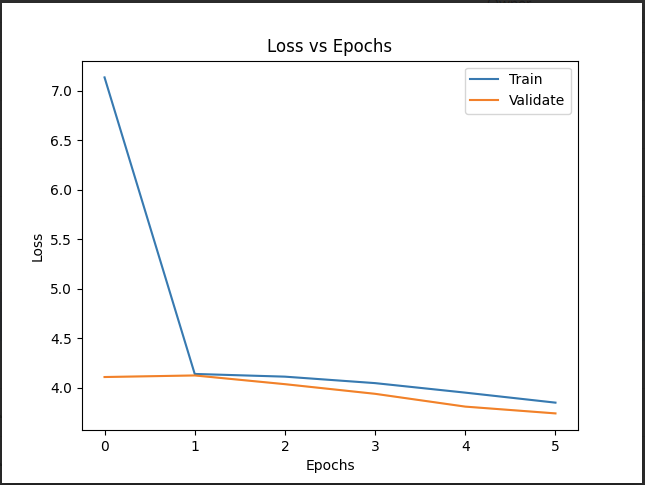

**Separate Training Loss:**

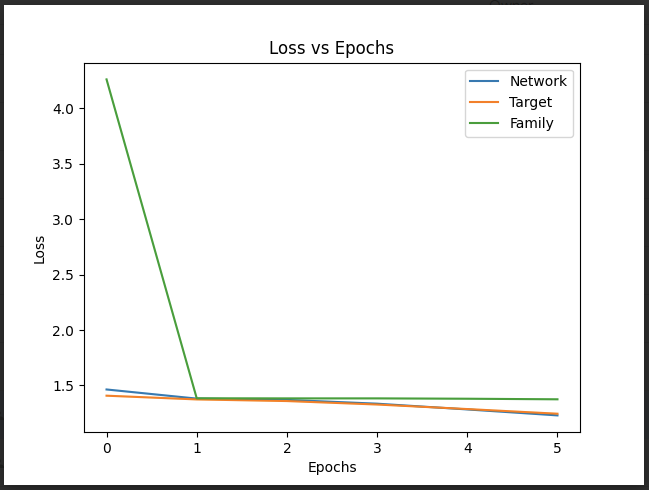

**Separate Validation Loss:**

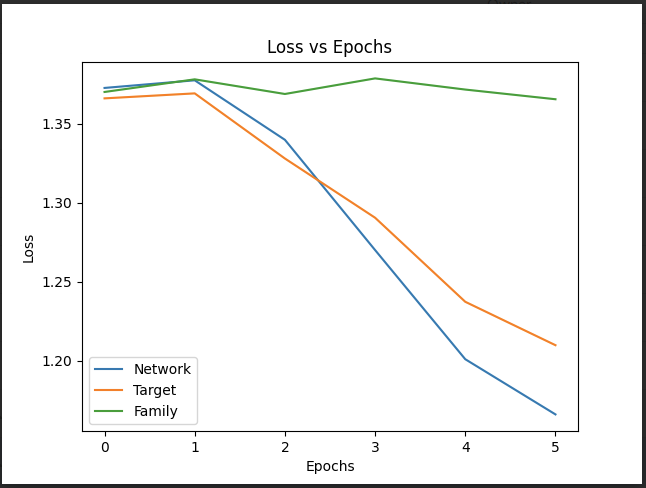

# GCN Graph Model

The GNN model using GCN layers for non-logitudinal data.

In [ ]:
# Declare data variables, loss function, and optimizer
model_type = 'graph'
gnn_layer = 'gcn'
pooling_method = 'target'
batch_size=250
main_hidden_dim = 20
lstm_hidden_dim = 20
dropout_rate = 0.5
learning_rate = 0.001
ratio = 0.5
gamma = 1
alpha = 1
beta = 1
delta = 1

fetch_data = DataFetch(model_type=model_type, featfile='featfile_G1.csv', gnn_layer=gnn_layer, alt_featfile='featfile_A2.csv')
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
num_features_static = len(fetch_data.static_features)
num_features_alt_static = len(fetch_data.alt_static_features)
num_samples_train_dataset = len(train_patient_list)
num_samples_valid_dataset = len(validate_patient_list)
num_samples_train_minority_class = fetch_data.num_samples_train_minority_class
num_samples_valid_minority_class = fetch_data.num_samples_valid_minority_class
num_samples_train_majority_class = fetch_data.num_samples_train_majority_class
num_samples_valid_majority_class = fetch_data.num_samples_valid_majority_class

model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, gnn_layer, pooling_method, dropout_rate, ratio)

loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)

Using GCN layers


**Below is the training step used to generate checkpoint file 'gnn-gcn.pt'**
<br> you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

In [ ]:
# compare you model with others
# num_epoch = 100
# num_batches_train = int(np.ceil(len(train_patient_list)/batch_size))
# num_batches_validate = int(np.ceil(len(validate_patient_list)/batch_size))

# start_time_train = time.time()
# # model training loop: it is better to print the training/validation losses during the training
# train_losses = []
# valid_losses = []
# separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

# model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/gnn-gcn.pt'
# gcn_early_stopping = EarlyStopping(path=model_path)
# for i in range(num_epoch):
#   model.train()
#   epoch_train_loss = []
#   separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

#   for train_batch in tqdm(train_loader, total=num_batches_train):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)

#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * loss_func(output, y)
#     loss_term_target = alpha * loss_func(patient_output, y)
#     loss_term_family = beta * loss_func(family_output, y)

#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())

#     loss = loss_term_NN + loss_term_target + loss_term_family

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     epoch_train_loss.append(loss.item())

#   # eval on validset
#   model.eval()
#   epoch_valid_loss = []
#   valid_output = np.array([])
#   valid_y = np.array([])
#   for valid_batch in tqdm(validate_loader, total=num_batches_validate):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = valid_batch.patient_x_static, valid_batch.x, valid_batch.y.unsqueeze(1), valid_batch.edge_index, valid_batch.edge_attr, valid_batch.batch, valid_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)

#     valid_output = np.concatenate((valid_output, output.reshape(-1).detach().cpu().numpy()))
#     valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * valid_loss_func(output, y)
#     loss_term_target = alpha * valid_loss_func(patient_output, y)
#     loss_term_family = beta * valid_loss_func(family_output, y)

#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())

#     loss = loss_term_NN + loss_term_target + loss_term_family
#     epoch_valid_loss.append(loss.item())

#   train_loss, valid_loss = np.mean(epoch_train_loss), np.mean(epoch_valid_loss)
#   train_losses.append(train_loss)
#   valid_losses.append(valid_loss)
#   for term_name in separate_loss_terms:
#     separate_loss_terms[term_name].append(np.mean(separate_loss_terms_epoch[term_name]))
#   print("epoch {}\ttrain loss : {}\tvalidate loss : {}".format(i, train_loss, valid_loss))
#   gcn_early_stopping(np.mean(epoch_valid_loss), model)
#   if gcn_early_stopping.early_stop:
#     print('Early Stopping')
#     break

# fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_output)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# threshold = thresholds[ix]

# plot_losses(train_losses, valid_losses, 'gcn')
# plot_separate_losses(separate_loss_terms['NN_train'], separate_loss_terms['target_train'], separate_loss_terms['family_train'], 'gcn', True)
# plot_separate_losses(separate_loss_terms['NN_valid'], separate_loss_terms['target_valid'], separate_loss_terms['family_valid'], 'gcn', False)

# end_time_train = time.time()

# torch.save({
#     'epoch': num_epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'threshold': threshold,
#     'start_time': start_time_train,
#     'end_time': end_time_train
#     }, model_path)

# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 111/111 [02:15<00:00,  1.32it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch 0	train loss : 3.8721207519909284	validate loss : 3.759416416287422


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


epoch 1	train loss : 3.853707350052155	validate loss : 3.722113162279129
EarlyStopping counter: 1 out of 5


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


epoch 2	train loss : 3.8099506631627813	validate loss : 3.686437338590622
EarlyStopping counter: 2 out of 5


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


epoch 3	train loss : 3.7877691092791856	validate loss : 3.6865831464529037
EarlyStopping counter: 3 out of 5


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


epoch 4	train loss : 3.7570300596254365	validate loss : 3.6524819284677505
EarlyStopping counter: 4 out of 5


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


epoch 5	train loss : 3.734771595344887	validate loss : 3.686576634645462
EarlyStopping counter: 5 out of 5
Early Stopping


<Figure size 640x480 with 0 Axes>

**Below is the testing step used to generate checkpoint file 'test-gnn-gcn.pt'**
<br>you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

In [ ]:
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper
# metrics to evaluate my model
# gdown.download('https://drive.google.com/uc?id=1-3ZZGCHYJbxOHWLE6SfEHSh2mfsblqW0')
# gnn_gcn_checkpoint = torch.load('/content/gnn-gcn.pt')
# gcn_model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, 'gcn', pooling_method, dropout_rate, ratio)
# gcn_model.load_state_dict(gnn_gcn_checkpoint['model_state_dict'])
# gcn_model.eval()

# gnn_gcn_threshold = gnn_gcn_checkpoint['threshold']
# gnn_gcn_start_time = gnn_gcn_checkpoint['start_time']
# gnn_gcn_end_time = gnn_gcn_checkpoint['end_time']

# num_samples = 3
# gnn_gcn_test_output = [np.array([]) for _ in range(num_samples)]
# gnn_gcn_test_y = [np.array([]) for _ in range(num_samples)]
# representations = pd.DataFrame()

# test_patient_list = fetch_data.test_patient_list
# num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
# test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

# gcn_test_model_path = raw_data_dir + 'drive/MyDrive/CS598 DLH/Project/test-gnn-gcn.pt'
# for m in gcn_model.modules():
#   if m.__class__.__name__.startswith('Dropout'):
#     m.train()

# for sample in range(num_samples):
#     for test_batch in tqdm(test_loader, total=num_batches_test):
#         x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = test_batch.patient_x_static, test_batch.x, test_batch.y.unsqueeze(1), test_batch.edge_index, test_batch.edge_attr, test_batch.batch, test_batch.target_index
#         output, patient_output, family_output = gcn_model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
#         gnn_gcn_test_output[sample] = np.concatenate((gnn_gcn_test_output[sample], output.reshape(-1).detach().cpu().numpy()))
#         gnn_gcn_test_y[sample] = np.concatenate((gnn_gcn_test_y[sample], y.reshape(-1).detach().cpu().numpy()))

# torch.save({
#     'epoch': num_samples,
#     'test_output': gnn_gcn_test_output,
#     'test_y': gnn_gcn_test_y,
#     'threshold': gnn_gcn_threshold,
#     'start_time': gnn_gcn_start_time,
#     'end_time': gnn_gcn_end_time
# }, gcn_test_model_path)

Downloading...
From: https://drive.google.com/uc?id=1-3ZZGCHYJbxOHWLE6SfEHSh2mfsblqW0
To: /content/gnn-gcn.pt
100%|██████████| 46.1k/46.1k [00:00<00:00, 24.9MB/s]


Using GCN layers


  0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [00:37<00:00,  1.17it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


In [ ]:
gdown.download('https://drive.google.com/uc?id=1ZwhjddpQ_4raLrN8598RhykWMbSLr5u4')
gnn_gcn_test_checkpoint = torch.load('/content/test-gnn-gcn.pt')
num_samples = gnn_gcn_test_checkpoint['epoch']
gnn_gcn_test_output = gnn_gcn_test_checkpoint['test_output']
gnn_gcn_test_y = gnn_gcn_test_checkpoint['test_y']
gnn_gcn_threshold = gnn_gcn_checkpoint['threshold']
gnn_gcn_start_time = gnn_gcn_checkpoint['start_time']
gnn_gcn_end_time = gnn_gcn_checkpoint['end_time']

# report standard error for uncertainty
gnn_gcn_test_output_se = np.array(gnn_gcn_test_output).std(axis=0) / np.sqrt(num_samples)

# take average over all samples to get expected value
gnn_gcn_test_output = np.array(gnn_gcn_test_output).mean(axis=0)
gnn_gcn_test_y = np.array(gnn_gcn_test_y).mean(axis=0)

gnn_gcn_results = pd.DataFrame({'actual':gnn_gcn_test_y, 'pred_raw':gnn_gcn_test_output, 'pred_raw_se':gnn_gcn_test_output_se})
gnn_gcn_results['pred_binary'] = (gnn_gcn_results['pred_raw']>gnn_gcn_threshold).astype(int)
gnn_gcn_metric_results = calculate_metrics(gnn_gcn_results['actual'], gnn_gcn_results['pred_binary'], gnn_gcn_results['pred_raw'])
print(gnn_gcn_metric_results)
print("start time: {}\tend time".format(gnn_gcn_start_time, gnn_gcn_end_time))


Downloading...
From: https://drive.google.com/uc?id=1ZwhjddpQ_4raLrN8598RhykWMbSLr5u4
To: /content/test-gnn-gcn.pt
100%|██████████| 440k/440k [00:00<00:00, 5.87MB/s]

{'metric_auc_roc': 0.7582678910645871, 'metric_auc_prc': 0.2615118219594704, 'metric_f1': 0.33721922092692636, 'metric_recall': 0.6792668957617412, 'metric_mcc': 0.2565234631792809, 'metric_ts': 0.2028043775649795, 'metric_bss': -0.7508168178511943, 'true_negatives': 4936, 'false_positives': 2051, 'false_negatives': 280, 'true_positives': 593}
start time: 1714321995.3606708	end time


**Loss:**

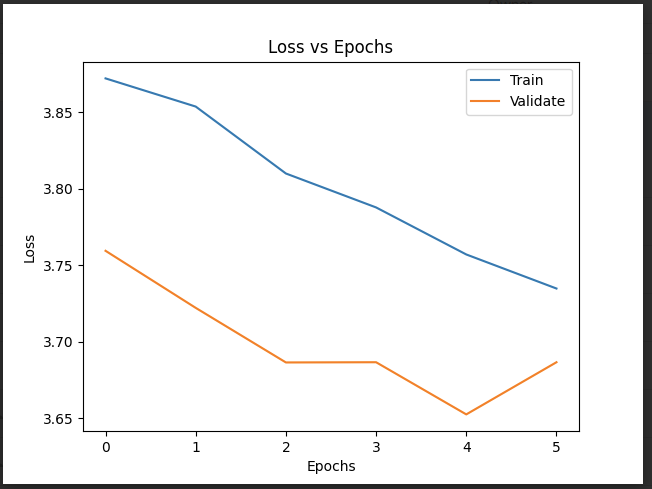

**Separate Loss:**

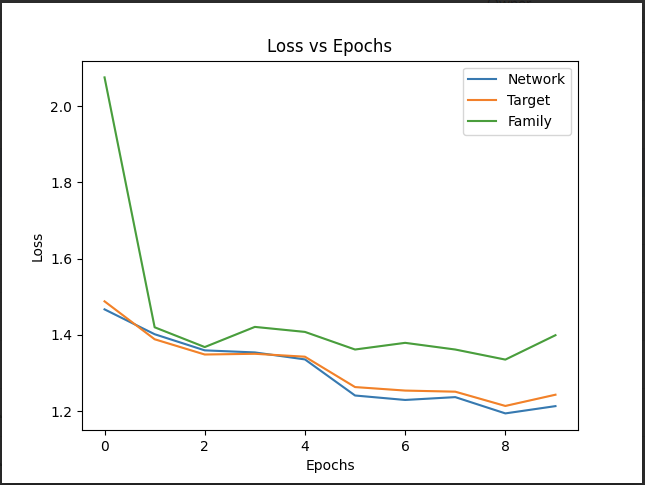

**Separate Training Loss:**

![image.png](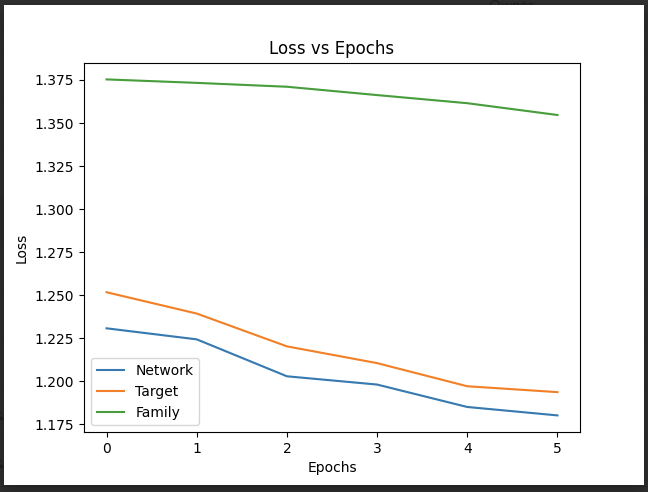
)

## Results
Below is the chart displaying the results from various models after testing. The first chart illustrates several key performance metrics: the area under the ROC curve (AUC), Precision-Recall Curve (AUC PRC), F1 score, recall, and Matthew's Correlation Coefficient (MCC). These metrics help determine which models are the most effective.

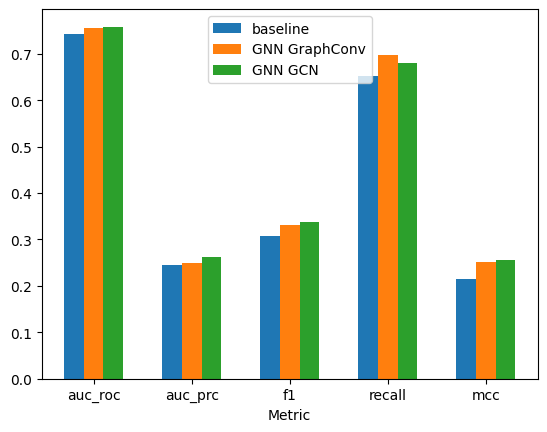

<Figure size 640x480 with 0 Axes>

In [ ]:
X = ['auc_roc', 'auc_prc', 'f1', 'recall', 'mcc']
X_axis = np.arange(len(X))
plt.bar(X_axis-0.2, list(baseline_metric_results.values())[:5], 0.2, label='baseline')
plt.bar(X_axis, list(gnn_graphconv_metric_results.values())[:5], 0.2, label='GNN GraphConv')
plt.bar(X_axis+0.2, list(gnn_gcn_metric_results.values())[:5], 0.2, label='GNN GCN')
plt.legend()
plt.xticks(X_axis, X)
plt.xlabel('Metric')
plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/metric-results.png')
plt.show()
plt.clf()

Below is a chart displaying the true negatives, false positives, false negatives, and true positives. This chart aids in understanding the outcomes of the models and facilitates a comparison of their performance.

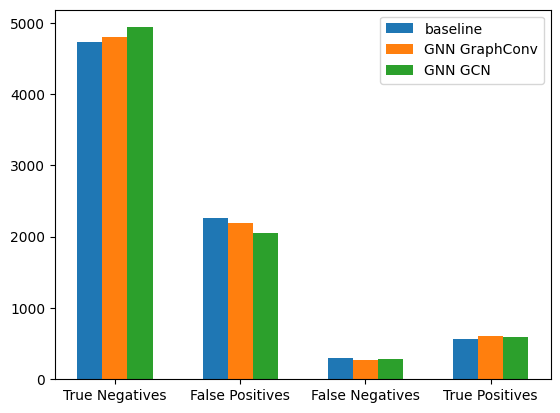

<Figure size 640x480 with 0 Axes>

In [ ]:
X = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
X_axis = np.arange(len(X))
plt.bar(X_axis-0.2, list(baseline_metric_results.values())[-4:], 0.2, label='baseline')
plt.bar(X_axis, list(gnn_graphconv_metric_results.values())[-4:], 0.2, label='GNN GraphConv')
plt.bar(X_axis+0.2, list(gnn_gcn_metric_results.values())[-4:], 0.2, label='GNN GCN')
plt.legend()
plt.xticks(X_axis, X)
plt.savefig(raw_data_dir+'drive/MyDrive/CS598 DLH/Project/metric-results-2.png')
plt.show()
plt.clf()

# Discussion

This paper is reproducible, and by following along with the paper itself, the related GitHub repository, and the synthetic data generator, we were able to replicate the paper's results. The authors made great efforts in making their work easily reproducible. Providing a synthetic data generator greatly simplified the process of replicating their work. Additionally, they provided a table comparing the results of their models to the baseline models, which made it simple to see if our work matched theirs.

The baseline model received a lower recall score than both of the graph-based models. In addition The area under the curve for the graph-based models (both graphconv and gcn layers) is slightly higher than in the baseline model. The F1 score for all three models is very similar, with the GraphConv graph model outperforming the other two models very slightly.

We also saw that the GCN GNN model performed better than the Graphconv model. This aligns with the hypothese we made above. Although the metrics are very similar, the higher auc_roc score and F1 score, with a very similar recall, show that the GraphConv model is slightly better.

Reproducing and training the models was straightforward since the dataset was readily provided by the authors. However, running the training code and comparing the metrics proved more challenging than anticipated due to the lengthy training times. To mitigate this, we decided to save the model checkpoints, allowing us to make changes to the model without the need for retraining.

There are no real changes the authors should make to improve the reproducibility of their paper. Providing the synthetic data generator, as well as a Github repository containing their work made it incredibly easy to follow their methodology.


In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

# References

1. Sun, J, "Characterizing personalized effects of family information on disease risk using graph representation learning.", Proceedings of Machine Learning Research, 2023, 219:1–25, doi: https://doi.org/10.48550/arXiv.2304.05010

